# Model Interpretabililty
## What's inside the black box?

The [code](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb) and [tutorial](https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-4-a536f333b20d) has been replicated from the ["Introduction to Machine Learning for Coders"](http://course18.fast.ai/ml) course offered by Jeremy Howard on fast.ai.

## When is a model interpretable?
When a human can understand the cause of a decision

## Why is it necessary?
- Knowing the why can help us learn more about the problem, the data, and reason why a model might fail. This is particularly important in high-risk and safety-critical tasks. For instance, an object detection system on self-driving car should detect cyclists 100 percent of the time. Suppose, from analysis of our model we observe that the most important learned feature is to recognize the wheels of a bicycle. This is can help us think of cases of bicycles with side bags that partially cover the wheels.
- Useful as a debugging tool in detecting bias. For example, a model that automates credit card approval or rejection discriminates against a minority.

If a model is interpretable, then the following things can also be ensured:
- Fairness
- Privacy
- Robustness
- Causality
- Trust

## Decision Trees

**Why?**
- Non-linear relationship between features and outcome
- Feature Interaction
- Suitable for tabular data
- Easy to interpret

**How?**  
- Split data multiple times according to cut-off values in the features

## Random Forests
- Collection of shallow decision trees
- Each tree learns from a subset of the data set
- Each tree learns from a subset of features
- Interpretable

## Load the required libraries

In [1]:
import sys
sys.path.append("../")
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
%matplotlib inline

In [2]:
set_plot_sizes(12,14,16)

## Load data

**Dataset:** [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/description)  competition hosted on Kaggle
**Goal:** Predict the sale price of different heavy equipments at an auction based on their usage, equipment types, and configurations. 

The training data, `bulldozers-raw`, used in this notebook has been preprocessed and saved as a feather file. The code for data preprocessing can be found [here](../notebooks/data-preprocessing.ipynb). We next convert the categories into integers, handle missing values, and obtain the target variable using the `proc_df` method from the FastAI library.

In [3]:
PATH = "../data/bulldozers/"

df_raw = pd.read_feather(PATH + '/bulldozers-raw') # pre-processed data
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice') # convert the categories into integers, handle missing values

We split the data into training and validation sets. 

In [4]:
def split_vals(a,n):
    return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

We calculate 5 performance metrics: 
- RMSE of training data set
- RMSE of validation data set
- $\mathtt{r^2}$ of the training data set
- $\mathtt{r^2}$ of the validation data set
- $\mathtt{r^2}$ of the out-of-bag (OOB) samples

<img src="../figures/rmse.png" width=250>
<img src="../figures/r-squared.png" width=350>

In [5]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [6]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200


## Feature Importance

This is the first and the most straight-forward step that we can follow for model interpretation. It tells us the most impactful features learned by the random forest.

The general workflow should be that we build a random forest as fast as we can which of course must be significantly better than random. But, it doesn't have be the best one. And the next thing we do is to plot the feature importance.    

For model interpretation, we can select a subset of the dataset which will be both faster and provide better interpretability by reducting overfitting. We can do this using the `set_rf_samples` method.

In [7]:
set_rf_samples(50000)

Train a Random Forest on the subset.

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20575341826924703, 0.24866044755212893, 0.9115232942451137, 0.8895765286140566, 0.8945584869265912]


Top 10 important features. FastAI library provides a method `rf_feat_importance` for getting the feature importances.

In [9]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.175144
37,Coupler_System,0.109634
13,ProductSize,0.109093
14,fiProductClassDesc,0.079945
2,ModelID,0.052869
63,saleElapsed,0.050103
10,fiSecondaryDesc,0.047023
39,Hydraulics_Flow,0.042593
38,Grouser_Tracks,0.041426
8,fiModelDesc,0.031984


From the plot above, we can observe that some columns are important while most of them don't matter much. Let's plot the top 30 most important features.

In [11]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

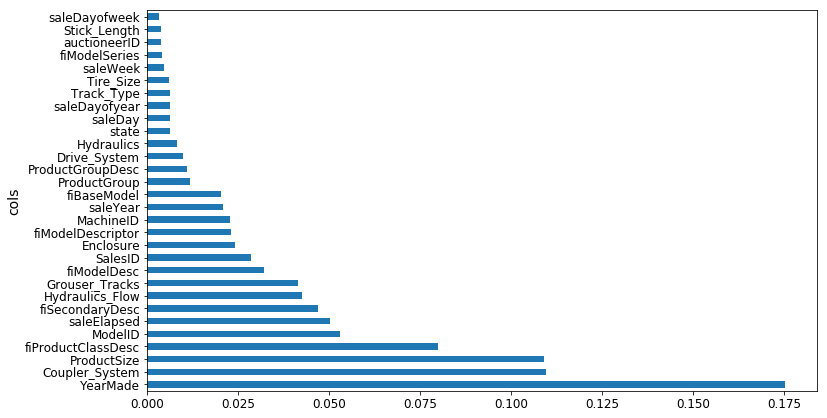

In [12]:
plot_fi(fi[:30]);

Let's only select the features whose feature importance is more than 0.005 (where the curve flattens). We will create a new random forest on the selected features.  

In a real-world data science problem, the next step would be to sit down with your client or a domain expert and obtain a deep understanding of what the important features mean. What will often happen in real-world projects is that we sit with the the client and find out that the important features found by your model doesn't make any sense. That doesn’t mean that there is a problem with our model. It means there is a problem with their understanding of the data we were provided. This could be an indication of a data leakage. 

The other thing that could happen here is collinearity. Collinearity occurs when two columns are related to each other. For example, `Coupler_System` tells us whether or not a particular kind of heavy industrial equipment has a particular feature on it. So, it indicates whether or not it is a certain class of heavy industrial equipment.

In [13]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

25

In [14]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

Let's train a Random Forest only on the set of selected features.

In [15]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20707203581767686, 0.24548966547940898, 0.9103856141899133, 0.8923746932729146, 0.8940667509783008]


Generally, removing redundant columns should not make our model worse. If it makes it worse, they were not redundant after all. It might make it a little bit better because the way trees are built. When a tree is deciding what to split on, it has less things to worry about trying and it is less often going to accidentally find a noisy column. So there is slightly better opportunity to create a slightly better tree with slightly less data, but it is not going to change it by much. But it is going to make it a bit faster and it is going to let us focus on what matters.  

Plotting the feature importance of the new model.

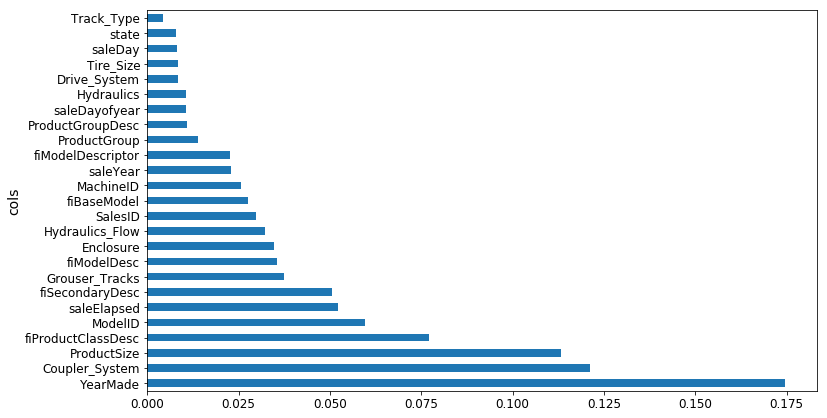

In [16]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Removing redundant features also helps removing sources of collinearity. Collinearity doesn't make random forests less predictive, but if you have a column `A` that is a little bit related to a column `B`, and B is strongly related to the target variable, what happens is that the importance is going to be split between `A` and `B`. By removing some of those columns with very little impact, it makes the feature importance plot clearer. Before `YearMade` was closer to `Coupler_System`. But there must have been a bunch of things that are collinear with `YearMade` and now you we can see that `YearMade` really matters. This feature importance plot is more reliable than the one before because it has a lot less collinearity to confuse us.

### How is feature importance computed?

This technique is model agnostic so can be used with any kind of model really. 
- We take our bulldozer data set and we have a column `Price` that we are trying to predict (target variable).
- We have 25 features and one of them is `YearMade`.
- How do we figure out how important `YearMade` is? We have a random forest and we can find out our predictive accuracy. So we will put all these rows through our random forest, and it will spit out some predictions. We will then compare them to the actual price (in this case, we get our RMSE and $\mathtt{r^2}$). This is our starting point.
- Let’s do exactly the same thing, but this time, take the `YearMade` column and randomly shuffle it (i.e. randomly permute just that column). Now `YearMade` has exactly the same distribution as before (same mean, same standard deviation). But it has no relationships with our dependent variable at all because we randomly reordered it.
- Before, we might have found our $\mathtt{r^2}$ was .89. After we shuffle `YearMade`, we check again, and now $\mathtt{r^2}$ is .80. The score got much worse when we destroyed that variable.
- Okay, let’s try again. We put `YearMade` back to how it was, and this time let’s take `Enclosure` and shuffle that. This time, $\mathtt{r^2}$ is .84 and we can say the amount of decrease in our score for `YearMade` was .09 and the amount of decrease for `Enclosure` was .05. And this is going to give us our feature importances for each column.  

<img src="../figures/feature-importance-illustration.png" width=600>

## One-hot encoding

The `max_n_cat` argument in `proc_df` turns categorical variables into new columns.

For example, the column `ProductSize` which has 6 categories:
- Large
- Large / Medium
- Medium
- Compact
- Small
- Mini

gets turned into 6 new columns:

- ProductSize_Large
- ProductSize_Large / Medium
- ProductSize_Medium
- ProductSize_Compact
- ProductSize_Small
- ProductSize_Mini
and the column `ProductSize` gets removed.  

It will only happen to columns whose number of categories is no bigger than the value of the `max_n_cat` argument.  

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.  

<img src="../figures/one-hot-encoding.png" width=500>

In [17]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2069222362368916, 0.253790549604401, 0.9105152245617099, 0.8849732454468142, 0.8928179275818589]


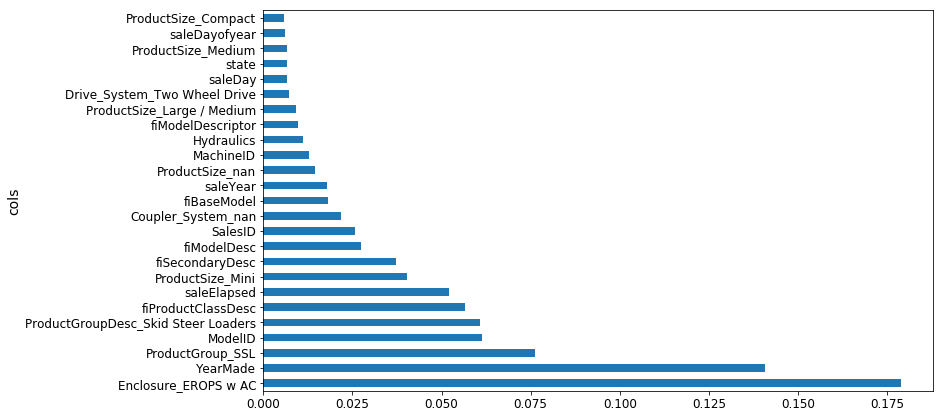

In [18]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## Removing Redundant Features using Dendrograms

We’ve already seen how features which are measuring the same thing can confuse our feature importance. They can also make our random forest slightly less good because it requires more computation to do the same thing and there’re more columns to check. So we are going to do some more work to try and remove redundant features. One way to achieve this is with the help of a **dendrogram**. And it is very similar to hierarchical clustering.  

We want to find the columns that are similar in a way that the random forest would find them similar (random forests do not care about linearity, they just care about ordering). So a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation) is the right way to think about that. Spearman’s R is the name of the most common rank correlation. 

<img src="../figures/rank-correlation.png" width=700>

In [19]:
from scipy.cluster import hierarchy as hc

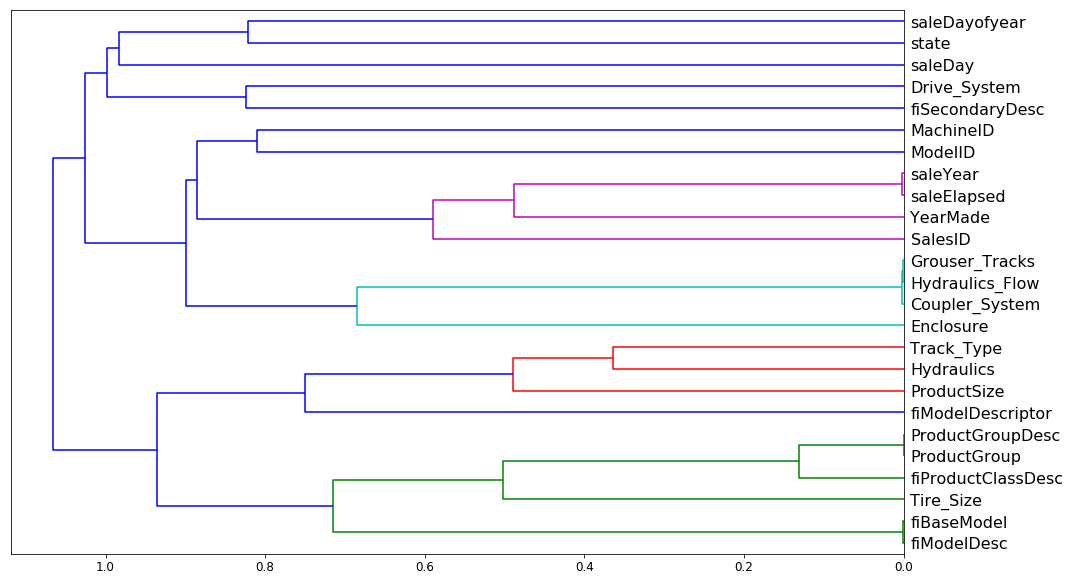

In [20]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4) # step 1: find the rank correlation between columns
corr_condensed = hc.distance.squareform(1-corr) # step 2: create a distance matrix
z = hc.linkage(corr_condensed, method='average') # step 3: establish hierarchical connections
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In the plot above, the horizontal axis refers to how similar two points are. If they are closer to the right, that means that they are very similar. So `saleYear` and `saleElapsed` are very similar which is intuitive since `current day - saleYear = saleElapsed`. `Grouser_Tracks`, `Hydraulics_Flow`, and `Coupler_System` all seem to be measuring the same thing. This is interesting because `Coupler_System` was found to be super important by our random forest. `ProductGroup` and `ProductGroupDesc` seem to be measuring the same thing, and so are `fiBaseModel` and `fiModelDesc`. Once we get past that, suddenly things are further away, so we're probably not going to worry about those. We are going to look into those four groups that are very similar.  

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [21]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Baseline OOB score.

In [22]:
get_oob(df_keep)

0.8904585634180603

The OOB score on the whole dataframe is 0.89 and after removing each of the columns, none of them led to a worse result. We refer to the dendrogram. Let’s take `fiModelDesc` and `fiBaseModel` which are very similar to each other. So, we can get rid of one of them because they are basically measuring the same thing. Uisng a similar logic we remove one column from each group.

In [23]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8897431523903078
saleElapsed 0.8871957465335669
fiModelDesc 0.8889384245693963
fiBaseModel 0.8889912392068378
Grouser_Tracks 0.8903969314389424
Coupler_System 0.8899121215329039


The OOB score on the whole dataframe is 0.89 and after removing each of the columns, none of them led to a worse result.

In [24]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8894677694163708

After removing 3 columns we almost have the same OOB score. So, we are going to remove this columns from the data frame and run the full model again.

In [25]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
np.save('../data/bulldozers/keep_cols.npy', np.array(df_keep.columns))

In [27]:
keep_cols = np.load('../data/bulldozers/keep_cols.npy')
df_keep = df_trn[keep_cols]

Let's see how this model looks on the full dataset.

In [28]:
reset_rf_samples() # uses the whole dataset

In [29]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12502251252401902, 0.22664772553525298, 0.9673328481686535, 0.9082616965464894, 0.9086157734213397]


So, now we have a simpler model that gives a better score. We have gotten rid of columns that didn't have good feature importance or were highly related to other features.

## Partial Dependence

This is powerful technique to understand the data by using our model. This helps us finding out the relationship of the target variable with the features.

In [30]:
from pdpbox import pdp
from plotnine import *

In [31]:
set_rf_samples(50000)

It should be interesting to see the individual levels of the categories for interpretation. So, we will use the dataframe that contained one-hot encoded categories.

In [32]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

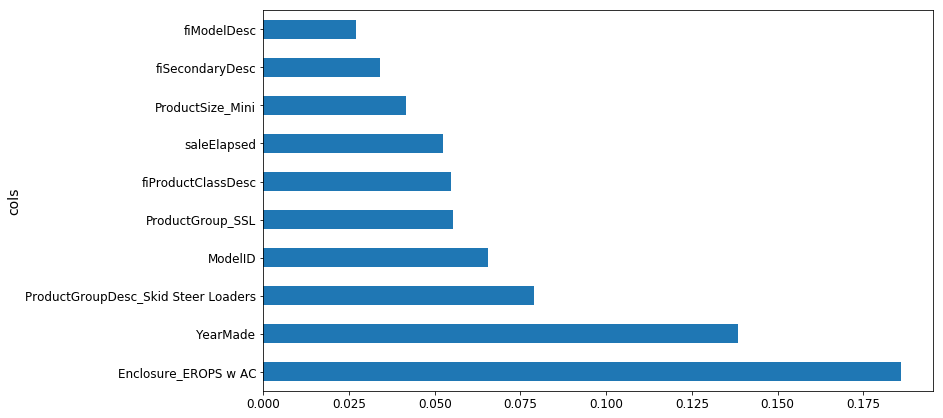

In [33]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

Let’s try to learn more about those top 10. `YearMade` is the second most important. So one obvious thing we could do would be to plot `YearMade` against `saleElapsed` because as we’ve talked about already, it seems to make sense that they are both important but it seems very likely that they are combined together to find how old was the product when it was sold. So we could try plotting `YearMade` against `saleElapsed` to see how they relate to each other.

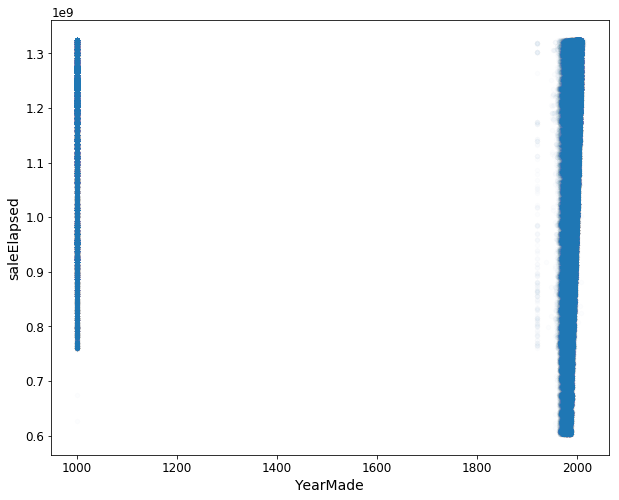

In [34]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

The plot shows that there are a bunch of bulldozers whose `YearMade` has been assigned 1000. This is certainly seems like a dummy variable assigned to bulldozers whose year of manufacture is probably unknown. So, we will remove these examples from our analysis.

In [35]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 1000)

Now let's look at the relationship between `YearMade` and `SalePrice`.

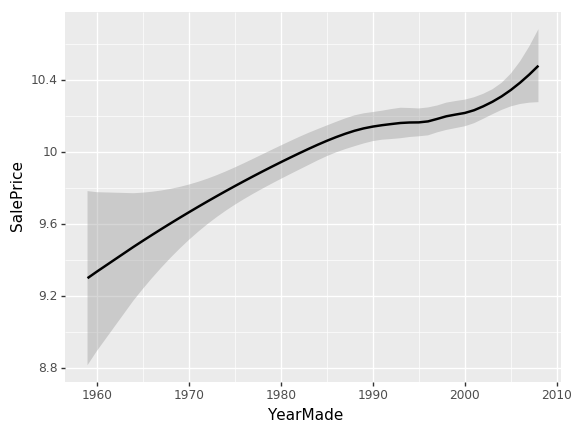

<ggplot: (-9223372029282647492)>

In [36]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

The plot we obtained is a little unexpected as we expect items sold recently to be more expensive due to inflation and because they are new models. The problem is that when we look at a univariate relationship like this, there is a whole lot of collinearity going on — a whole lot of interactions that are being lost. For example, why did the price drop? Is it actually because things made between 1991 and 1997 are less valuable? Or is it actually because most of them were also sold during that time and there was maybe a recession then? Or maybe it was because products sold during that time, a lot more people were buying types of vehicles that were less expensive? There’s all kind of reasons for that.  

So what we really want to investigate is the relationship between `SalePrice` and `YearMade` all other things being equal. "All other things being equal" basically means if we sold something in 1990 vs. 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price? To do that, we do something called a partial dependence plot.  

We are now going to try and create a chart where we say all other things being equal in 1960, how much did things cost in auctions? The way we are going to do that is we are going to replace the `YearMade` column with 1960. We are going to copy in the value 1960 again and again all the way down. Now in every row, the year made is 1960 and all of the other data is going to be exactly the same. We are going to take our random forest, we are going to pass all this through our random forest to predict the sale price. That will tell us for everything that was auctioned, how much do we think it would have been sold for if that thing was made in 1960.

<img src="../figures/pdp-illustration.png" width=600>

In [37]:
x = get_sample(X_train[X_train.YearMade>1930], 1000)

In [38]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

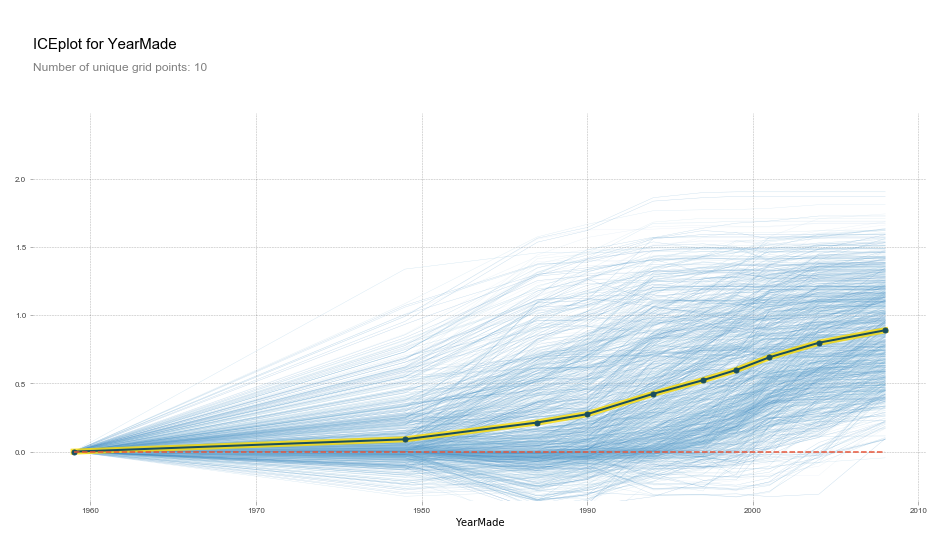

In [39]:
plot_pdp('YearMade')

Each of light blue lines is the number of examples/rows that we selected for investigation. Each point on a line tells us the price the item would be sold for if it were made during the year corresponding to the point with all other features staying the same. The dark line is the average. So this tells us how much would we have sold on average all of those auctions for if all of those products were actually made in 1985, 1990, 1993, etc. So we can see that in the period where we have a reasonable amount of data which is since 1990, we get a straight line - which is what we would expect. Because if it was sold on the same date, and it was the same kind of equipment, sold to the same person in the same auction house, then we would expect more recent vehicles to be more expensive because of inflation and they are newer. We would expect that relationship to be roughly linear and that is exactly what we are finding. By removing all these externalities, it often allows us to see the truth much more clearly.  

We can also group the blue lines into clusters. What clusters does is it uses cluster analysis to look at each one of the 1000 rows and say do some those rows move in the same way. It seems like there’s a whole a lot of rows that go down and then up, and there seems to be a bunch of rows that go up and then go flat. It does seem like there’s some kind of different types of behaviors being hidden.

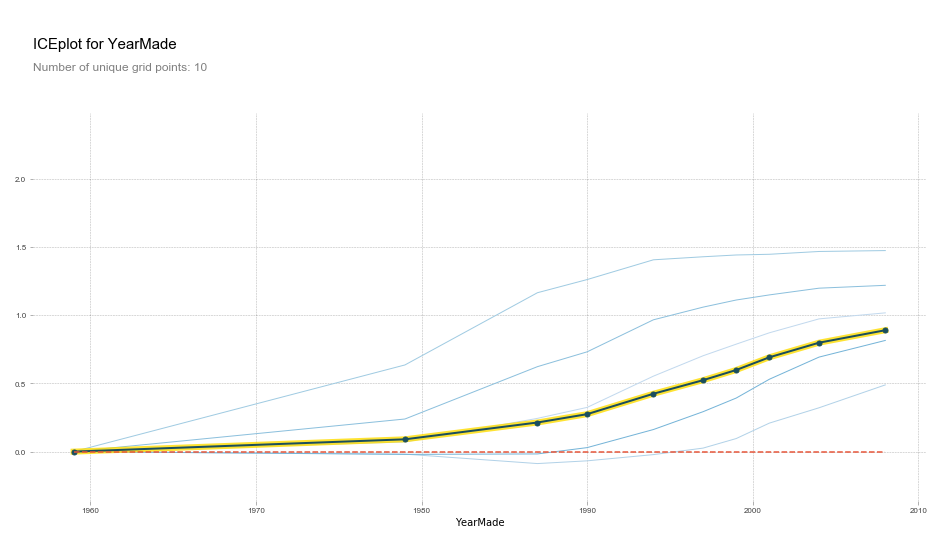

In [40]:
plot_pdp('YearMade', clusters=5)

The plot above is the result of the clustering. We still get the same average but it says here are five most common shapes that we see. And this is where we could derive some insights. For example, it looks for like some kinds of vehicle, after 1990, the prices are pretty flat. Before that, they were pretty linear. Some other kinds of vehicle were exactly the opposite, so different kinds of vehicle have these different shapes. So, this is something we could further investigate.  

PDPs can help gain insights that might make us realize that we could transform this variable or create this interaction, etc. For example, the univariate plot of `SalePrice` vs `YearMade` which showed a dip in prices based on things made between 1990 and 1997 was due to something else going on at that tine. In reality the prices were increasing, as we saw in the PDP.

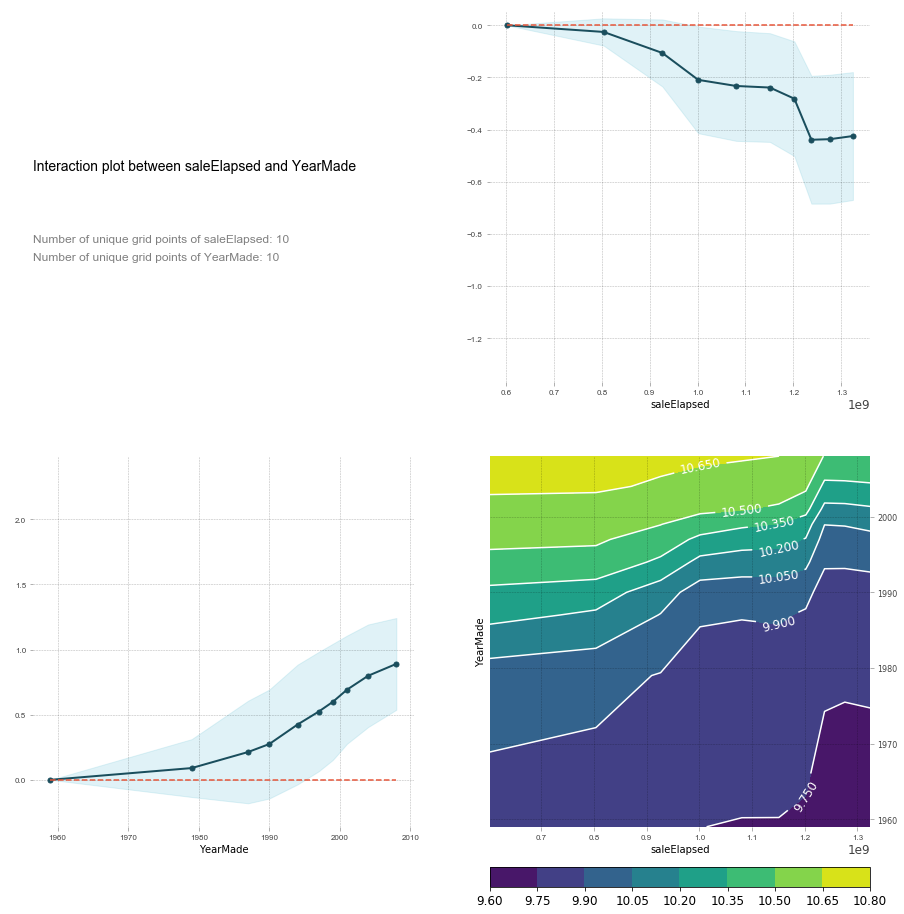

In [41]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

We could also do the same thing in a PDP interaction plot. If we do a PDP interaction plot to see how `saleElapsed` and `YearMade` together impact the price, it shows us `saleElapsed` vs. `price`, `YearMade` vs. `price`, and the combination vs. `price`. We took the log of the price and hence thes prices look weird. We can see that the combination of `saleElapsed` and `YearMade` is as we would expect - the highest prices are those where there’s the least elapsed and the most recent year made. The upper right is the univariate relationship between `saleElapsed` and `price`, the lower left is the univariate relationship between `YearMade` and `price`, and the lower right is the combination of the two. It’s enough to see clearly that these two things are driving `price` together. We can also see these are not simple diagonal lines so there is some interesting interaction going on. This is enough evidence to put in some kind of interaction term and see what happens.  

We next look at the one-hot encoded categorical variable `Enclosure_EROPS w AC` which was found to be the most important feature by the random forest. We can pass an array containing the names of the features to plot_pdp and it will treat them as a category.

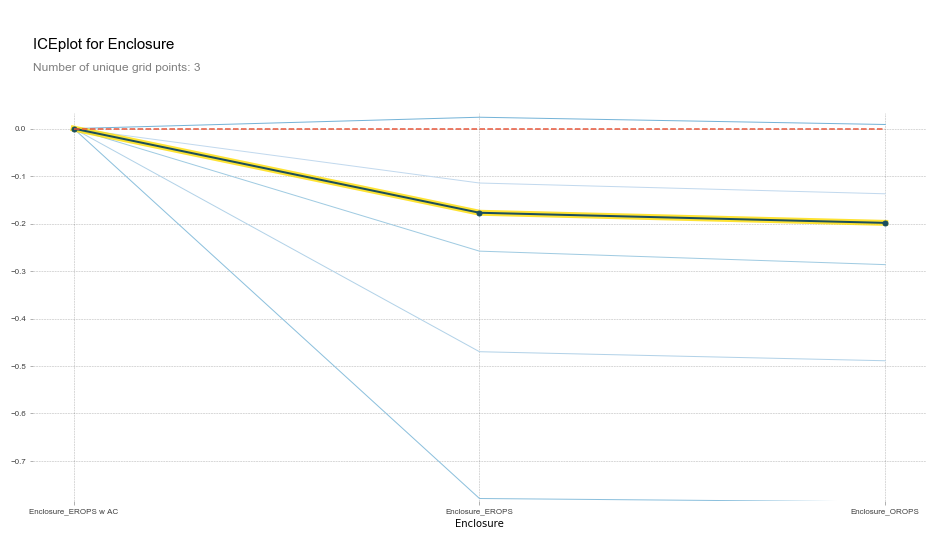

In [42]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

We can observe that `Enclosure_EROPS w AC` on average are more expensive than `Enclosure_EROPS` or `Enclosure_OROPS`. But what do these categories mean? EROPS stands for enclosed rollover protective structure and so it turns out that if a bulldozer is fully enclosed then optionally we can get air conditioning. So actually this thing is telling us whether it has air conditioning. If it’s an open structure, then obviously we can'tt have air conditioning. So we’ve now learnt all other things being equal, the same bulldozer, sold at the same time, built at the same time, sold to the same person is going to be quite a bit more expensive if it has air conditioning than if it doesn’t. So again, we are getting this nice interpretation ability. From the previous feature importance plot we noticed that knowing this is the most important thing. There are a lot more air conditioned bulldozers nowadays than they used to be and so there is definitely an interaction between date and that.  

Based on our previous interaction analysis, we set everything before 1950 to 1950 to handle the missing values. We create a new variable `age` which is `saleYear - YearMade` and train a random forest again.

In [43]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

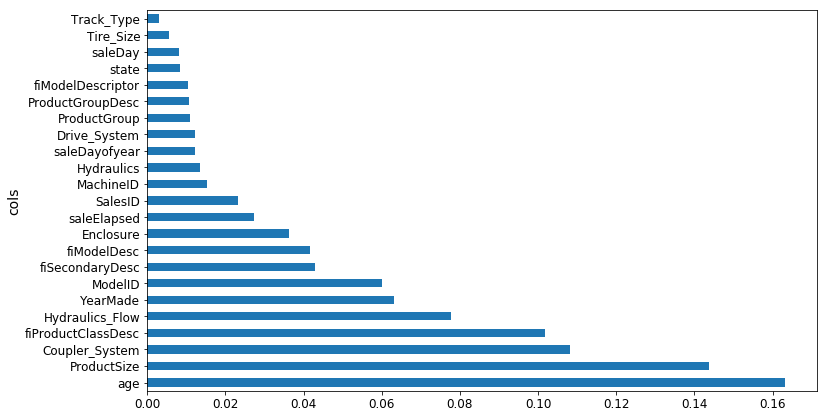

In [44]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

`age` is now the most important feature.

## Tree Interpreter

Tree intepreter is super important in businesses and real life. Let's understand the motivation behind it using an example. Let’s say we are an insurance company and somebody rings us up and we give them a quote and they say "oh, that’s $500 more than last year. Why?". So in general, we’ve made a prediction from some model and somebody asks the reason behind the prediction. This is where we use this method called tree interpreter.

What tree interpreter does is that it allows us to select a particular row and pass in our random forest and it gives back three values:
- prediction: the predicted sale price using the random forest for that row
- bias: the average sale price across the whole dataset
- contributions: a feature (column), its value/sub-category in the row, and how much it changed the predicted value w.r.t the bias

In [45]:
from treeinterpreter import treeinterpreter as ti

In [46]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [47]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
              3232,    4364751,          1,          0,    2300944,          4,          4,          0,
                12,         35,         16,        259,          2,          0,         11]])

In [48]:
X_valid.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Hydraulics_Flow',
       'fiModelDesc', 'SalesID', 'Enclosure', 'fiModelDescriptor', 'MachineID',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Hydraulics',
       'state', 'saleDay', 'saleDayofyear', 'Track_Type', 'Tire_Size', 'age'],
      dtype='object')

In [49]:
prediction, bias, contributions = ti.predict(m, row)

In [50]:
prediction[0][0], bias[0]

(9.33801454866563, 10.105472148038817)

In [51]:
idxs = np.argsort(contributions[0])

In [52]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5496412981737588),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11587140908391383),
 ('age', 11, -0.11164980819712547),
 ('fiModelDesc', 'KX1212', -0.10162360608241232),
 ('fiSecondaryDesc', nan, -0.04076280227768434),
 ('Enclosure', 'EROPS', -0.023767588112543158),
 ('saleElapsed', 1284595200, -0.018384281474834063),
 ('SalesID', 4364751, -0.013880998901440789),
 ('Tire_Size', nan, -0.010137020256005557),
 ('saleDayofyear', 259, -0.009528911469517575),
 ('ProductGroup', 'TEX', -0.0072672852373886435),
 ('fiModelDescriptor', nan, -0.004498687645480981),
 ('saleDay', 16, -0.0037540180990309757),
 ('Hydraulics', 'Standard', 0.003030061416758123),
 ('ProductGroupDesc', 'Track Excavators', 0.005611634506642682),
 ('state', 'Ohio', 0.0058528692376771385),
 ('MachineID', 2300944, 0.007038746535535179),
 ('Drive_System', nan, 0.009643065746861667),
 ('ModelID', 665, 0.015840885155305972),
 ('Track_Type', 'Steel', 0.024262289

In [53]:
contributions[0].sum()

-0.7674575993731888

In [54]:
prediction[0][0] - bias[0]

-0.7674575993731878

<img src="../figures/tree-interpreter.png">

So, how does the tree interpreter work? Let's take a look at a sample decision tree from the random forest. The batch of data that this tree was trained on has an average log sale price of 10.189. In our selected row, the value for `Coupler_System` is 0 ( $\le$ 0.5 ). Then we get an average log sale price of 10.345 ( *contribution* = +0.156 ). We then further select the subset in which `Enclosure` = 1 ( $\le$ 2.0) and the average log sale price comes down to 9.955 ( *contribution* = -0.39 ). Then in the final split, `ModelID` = 665 ( $\le$ 4573.0 ) and hence the average log sale price goes up to 10.226 ( *contribution* = +0.271 ). Now, this of course is a sample tree trained on a subset of the training data on a selected group of features. There will be many such trees in our random forest and we average values over all these trees to get the final contributions.  

We can represent the contributions with a help of a waterfall chart which is widely popular in management, consulting, and business.  

<img src="../figures/waterfall-chart.png" width=640>

So, now if someone asks, "how come this particular auction’s prediction was this particular price?", we can answer “because these three things had these three impacts”.  

So, a small piece of industrial equipment meant that it was less expensive. If it was made pretty recently meant that it was more expensive, etc. This analysis is going to help a lot in a production environment. So, if we are going to use a machine learning model, we should grab a few example of actual customers or actual auctions and check whether our model looks intuitive. For instance, if the prediction of our model is that lots of people are going to really enjoy a crappy movie, and a friend comes up and tells us, “wow, that was a really crappy movie” then they’re going to come back and say “explain why your model is telling me that I’m going to like this movie because I hate that movie”. Then we could go back and say well, it’s because he/she liked a particular movie and because he/she in this age range and he/she this gender, and on average actually people like him/her did like that movie. 

## Resources

- [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) by Jeremy Howard
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar

## Other Model Interpretation packages

- [LIME](https://github.com/marcotcr/lime)
- [SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap)